## Uncovering Social Media Trends With ETPOL
### COSC-247 Machine Learning: Application Final Project Writeup
### Fynn Hayton-Ruffner

### Overview

Identifying political bias has always been a topic of great fascination for machine learning practicioners. Though this topic spans a wide breadth of distinct application areas, particular attention is paid to bias in news articles. While the value of article classification is undeniable, I was more interested in working to classify the political ideology of social media posts. With a well performing political bias classifier, one could apply it to any social media thread to gain a better understanding of who dominates the discussion (at least on that thread). One could imagine doing a cross-media search on certain keywords, and averaging the results of each platform to get a broad idea of who cares about what. The applications here are pretty diverse. For the purposes of this project, I wanted to see if I could uncover any trends from subreddits discussing topics I was interested in: r/climatechange, r/nba, r/guns, r/democrats, r/Republican, r/saturdaynightlive, r/abortion. Some of these threads have overtly political boundaries (you would expect that conservative leaning posts would dominate the guns subreddit), so they act as a control. I was primarily interested in looking at the results of climatechange, nba, saturdaynightlive, and abortion.

A range of prior research inspired me to look into this topic. AlDahoul et al. (2024), using a dataset of over 11 million youtube videos, fine-tuned the BERT transformer to achieve an accuracy of 75% and an F1-score of 77% when classifying the political leanings of the videos solely by their titles. Kim et al. (2022) also tuned BERT, this time to news articles, and acheived an impressive F1 score of 0.71 despite a relatively small amount of annotated data. 

It should also be mentioned that work in this field is not limited to transformers. Misra et al. (2016) trained a simple LSTM to classify with an F1 of 0.718. Biessmann (2016) employed more simple statistical modeling techniques to acheive above chance accuracy on political bias classification. Even less recently, Durant et al. (2006) managed to classify the political leanings of twitter posts with an accuracy of 78.06% using Naive Bayes and 75.47% with SVMs.

I coded a transformer using Pytorch to try to compete with the model performance of prior research. I wanted to use a transformer because 1) they are super interesting and I wanted to learn more about them through experience and 2) they tend to be great at text based tasks because of the attention mechanism. Admittedly, all the deep learning studies mentioned above discuss how this enhanced performance requires a huge amount of data, so I was hesitant about the dataset I created (~150,000 labeled posts). Nonetheless, I created ETPOL (Encoder Transformer for Political Orientation Labeling) to try to better understand the dynamics of the subreddits mentioned above. In the following writeup, I describe the data and ETPOL, outline the entire training/tuning process and resulting model, explain its application to the subreddits, and finally, discuss conclusions, implications, and future work.

##### The Subreddit Data

The posts from my subreddits of interest were scraped using the RedditExtractoR package in R. I used this package for another project in the past, so I knew it would be great for scraping and formatting ~1000 posts for any subreddit in a few lines of code. The actual scraping job is done in './scrape/reddit_scrape.R. The inital csv containing all the scraped posts from every subreddit is './scrape/scraped_posts.csv'. After cleaning this file in './one_off_scripts/prep_subreddits.ipynb' the reformatted dataset was saved to './scraped/subreddits_cleaned.csv'.

##### The Training Data

I had to find a sizeable number of social media posts labeled by political inclination. Luckily, I found two datasets on kaggle: [a Messy Twitter Dataset](https://www.kaggle.com/datasets/cascathegreat/politicaltweets) with ~130,000 posts, and [a Clean Reddit Dataset](https://www.kaggle.com/datasets/neelgajare/liberals-vs-conservatives-on-reddit-13000-posts/data) with ~13,000 posts. While I was lucky to find these datasets, they were structured completely differently, so combining them into one took a lot of cleaning and reformatting. I have the full cleaning process in 'clean_data.ipynb' but in short, I reformatted the post content of the messy dataset, removed everything that was not alphanumeric or punctuation with regex, renamed columns for consistency, and dealt with invisible unicode chars. After all that, I was able to join the two datasets together to create an 'all_posts.csv' file with 146,478 rows and two columns: 'content' & 'affiliation' (with values left or right); this size is far greater than anything I worked with this semester in this class but it is still relatively small in the grand scheme of ML. For reference, both the polished dataset and the raw csv files are in the 'data' directory of this project.

In [91]:
# a little data exploration
import pandas as pd
from pathlib import Path

print('A LOOK AT THE DATASET')
df=pd.read_csv(Path('data/all_posts.csv'))
content_lengths = df['content'].apply(len)
# Find the 98th percentile
percentile_99 = content_lengths.quantile(0.99)
class_counts = df['affiliation'].value_counts()
print(f'Dataset has {len(df)} rows')
print(f'99% of the posts in this dataset are <= to {int(percentile_99)} characters')
print(f'Class counts: {class_counts}')
print(f'Dataset is {round((77447/146478) * 100.0, 2)} % left and {round((69031/146478) * 100.0, 2)} % right, so class imbalance does not seem to be a big issue')

df.head()

A LOOK AT THE DATASET
Dataset has 146478 rows
99% of the posts in this dataset are <= to 384 characters
Class counts: affiliation
left     77447
right    69031
Name: count, dtype: int64
Dataset is 52.87 % left and 47.13 % right, so class imbalance does not seem to be a big issue


,content,affiliation
0,when you look at the history of big social mov...,left
1,it was great to be back in new jersey! there's...,left
2,"virginians delivered for me twice, and now im ...",left
3,some of the most important changes often start...,left
4,glad i had a chance to talk with our new champ...,left


##### The Tokenizer
After preprocessing the data, the next step in text analysis was to create a tokenizer that maps text to the numerical format necessary to pass it through a transformer. I documented the process in 'tokenizer.py' but will summarize it here. To start, I created a word piece tokenizer following the tutorial on [huggingface.com](https://huggingface.co/learn/llm-course/en/chapter6/8). Word piece is a subword tokenizer that breaks words into meaningful sub-units. For example, 'modernization' may become 'modern' & 'ization' since 'ization' may be encountered as a common suffix. This tackles the common issue of unknown words in new data. Since the tokenizer always starts from every character encountered in the vocabulary, as long as the input text doesn't have any new characters it is able to handle it. Given the size of the dataset and that I formatted the input data to only include alphanumeric chars and punctuation, it is very unlikely for the tokenizer to encounter characters not already in its vocabularly. After training the tokenizer on my dataset in tokenizer.py, I saved its state in the 'wp_tokenizer' directory. It has a 20,000 token vocabulary, which was more than enough to account at least for all the unique characters in my dataset. I provide an example below of how the tokenizer encodes a string into its numerical representation and back again. You will notice if you run it that not only is the decoded text string normalized (to lower case and uniform whitespace separation), but a new [CLS] token appears at the front. It is standard practice in text classification tasks to include this special CLS token as the token from which the class probabilities of the entire text are extracted (CITE BERT).

In [92]:
from transformers import PreTrainedTokenizerFast
from pathlib import Path 

test_str = "I am a test string!"
tokenizer = PreTrainedTokenizerFast.from_pretrained(Path('wp_tokenizer'), model_max_length=25)

tokenized = tokenizer.encode(test_str)
print(f'Tokens: {tokenized}')
print(f'Decoded tokens: {tokenizer.decode(tokenized)}')

Tokens: [2, 33, 157, 25, 1530, 19216, 3]
Decoded tokens: [CLS] i am a test string !


##### ETPOL
I decided to try to code my own encoder model using the pytorch module, since transformers tend to outperform other machine learning models on text related tasks. The reason for this gap is attention, the key process of a transformer that enriches the meaning of every token by the context that surrounds it (kind of like how we interpret text). To create the model, I followed the pure encoder structure laid out by [Attention is All You Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). Below, I detail the flow of any input sequence of text through the model. I set the max context length of ETPOL to a reasonable 512 tokens, so anything longer got truncated and anything shorter got padded to that length.

Input **X** shape: (512) -> 512 tokens in input sequence

1: Embedding layer (20,000 x d_model matrix): holds the embedding vector (of size d_model) of every token in the vocabulary (20,000 total). The embedding is meant to encode the meaning of every token numerically. It is the values within each embedding vector that are updated by the encoder with the idea that, by the end of the process, the output embedding of each token comes to represent the reality of what that token means within the context of the sequence. Each input token passes through this layer by indexing its corresponding row in the matrix, and thus every token is transformed into its corresponding embedding vector.

X shape: (512 x d_model): now every token is represented by an embedding vector of dimension d_model

2: Positional Encoder: The positional encoder is a 512 x d_model matrix that, in each row, holds an embedding for every possible position in the input sequence. For example, the token in the 5th position in input sequence has the embedding of the 5th row of this matrix added to it. This process happens for every token embedding in the input

X shape: (512 x d_model): the same shape, but each token embedding has been encoded with positional information

3: Encoder block:
First step: Attention:
    Attention begins by transforming any input token into 3 distinct embeddings via weight matrices: 
        1) the query: the vector represenation of an input embedding as the current token being processed in the sequence
        2) the key: the vector representation of an input embedding as a preceding token in the sequence
        3) the value: the actual value representation of a preceding token - used to update the current token after being scaled by its similarity (see below).
    For every input token i, the following process takes place for all preceding tokens j:
        The 'similarity' between i as a query vector and j as a key vector is computed by scaled dot product (which divides by the shape of the key vector). This similarity score is normalized with softmax and serves as scaler for value vector of j. The intuition is that the more similar the two tokens are, the more influence the j value vector will have on the encoded ouput of i. Thus, every preceding token is weighted by its similarity to the current token, and these products are summed up to produce an output vector which is then added back to the initial input embedding of token i. Theoretically, i now contains a more richer reprsentation of that tokens meaning by attending to its context.
    MULTI-HEAD ATTENTION: In practice, the attention process described above is divided among multiple heads, each of which handle different sections of any input embedding. The idea here is that each head learns to be responsible for different linguistic patterns between the token and the context. The query, key, and value vectors for every token in each head are shape d_model/num_heads, and the resulting attention output from each head for any token i is concatenated together prior to updating the input embedding of i.

X shape: (512 x d_model): the same shape, but each token embedding has been updated significantly by the attention output

Next: FeedForward MLP
    After attention, the other core component of an encoder block is the feedforward neural net. The input is transformed into a higher dimension (d_hidden), flows through the hidden layers that apply the ReLU activation function to weighted sum of each node (at least that's what I did), whose ouput is transposed back to the same shape as the input. Neural networks excel at discovering non linear relationships between inputs; the encoder takes advantage of that here. The output of the neural net is again shape 512 x d_model, holding new embedding representations from each token. These values are added to the attention updated embeddings.

* I'm leaving out layer normalization and dropout, but note that I did apply those methods in each encoder block.
The input passes through an arbitrary number of these encoder blocks, the idea being that by the end of the stack, their embeddings hold rich contextual and linguistic information that will result in better performance on the task at hand.

X shape: (512 x d_model): the same shape, but each token embedding has been updated significantly by the attention output, and feedforward.


4: Linear output: after being passed through the linear output, I extract the [CLS] token, which is inserted at the beginning of every input sequence. This token is meant to contain the label for classfication tasks after sufficient training, and is a common method for classfication in transformers. The embedding of the token is reduced from shape d_model to shape 2 (for two classes) by a linear layer. The two values here are meant to hold the class probabilites of the input sentence.

X shape (2): the unnormalized logit probabilities for the text belonging to each class for which there are 2 in my case.

Below is an example pass through the model using a random observation in the dataset.

In [93]:
import torch
import torch.nn as nn
from transformers import PreTrainedTokenizerFast
from models import ETPOL
from pathlib import Path
from PostsDataset import PostsDataset

context_length = 512
d_model = 512

model = ETPOL(
    vocab_size=20000,
    context_length=context_length,
    d_model=d_model,
    num_heads=8,
    num_hidden_layers=2,
    d_hidden=2048,
    num_encoders=8,
    pdrop=0.5
)

tokenizer = PreTrainedTokenizerFast.from_pretrained(Path('wp_tokenizer'), model_max_length=context_length)
# creates a dataset object from the dataframe, which internally handles tokenizing the inputs
dataset = PostsDataset(df, tokenizer, context_length)
rand_example = dataset.__getitem__(3)


In [94]:
reverse_label_map = {1: 'left', 0: 'right'} # this is the scheme I used to encode labels
inputs = rand_example['input_ids'].unsqueeze(0) # add the batch dimension (expected by model, used to speed up training)
print(inputs)
label = rand_example['labels']
outputs = model(inputs)
print(outputs)
print(outputs.shape) # class probs, one for each class, first dimension is batch size

tensor([[    2,   719,   113,    90,   798,   832,  4055,  2876,  1018,   107,
           565,  9804,    11,   159,     6,    43,   658,    33,     6,    37,
           473,    96,   364,   480,  6505,   119,    90,  2861,   565,  7119,
            11,    33,  1337,   160,     6,  1577,   398,   289,   109,    90,
            28, 12647,    59,   107,  2651,   503,   370,   874,    11,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,  

In [95]:
# lets look at the result! this is an untrained model so there is no significance to its prediction, especially given the binary nature of the classification
print(f"input post was: {tokenizer.decode(rand_example['input_ids'])}")
print(f"its label was: {reverse_label_map[int(label)]}")
print(f"It was predicted to be: {reverse_label_map[int(torch.argmax(outputs, dim=-1))]}")

input post was: [CLS] some of the most important changes often start in state legislatures . that ' s why i ' m proud to support these candidates for the virginia state legislature . i hope you ' ll join me and the d ##lc ##c in giving them your vote . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

##### TRAINING & HYPERPARAMETER TUNING

I have now described data preprocessing, creating the tokenizer, and the model structure. In the description of ETPOL above, I mention a lot of components (number of heads, number of encoder blocks, dimension of embeddings, hidden layers, dimension of hidden layers etc.) To be clear, I did not know beforehand what the best configuration of these model hyperparameters would be, so I left that up to training. There was also the question of learning rate, batch size, and dropout rate (for regularization). After testing my training loop code in main.py, which trains one model with a given set of parameters and saves its by-epoch results with model state, I set up an optimization script using the [Optuna Library](https://optuna.org/). Before I go over that however, I want to make sure to briefly describe the training methods (available in test_utils.py). I used the AdamW optimizer, a more advanced version of Stochastic Gradient Descent, and the Cross Entropy loss function, which is useful for binary or multi-classification tasks. I split the dataset into 70% train, 15% validation, and 15% test, and wrapped dataloader objects around each (this object shuffles and batches observations into a format compatible with the model & allows for more efficient training). For every epoch of the training loop, each batch of training data was used to calculate loss and update the weights of the model via backpropogation (see train function in test_utils.py). At the end of each epoch, model performance on the training and validation sets was evaluated via accuracy, average loss, precision, recall, F1 (see evaluate_model in test_utils.py). Finally, at the end of training, I evaluated each model on the test set. 

We spent a good amount of time in class talking about hyperparameter tuning, so I wanted to make sure I incorporated that into the project. However, since I wasn't directly using a sklearn model, I decided to look into other methods. Optuna is a library with a friendly user interface that allows you to create study objects. These objects take in an objective function (see objective in opt.py) that can either be minimized or maximized. It allows you to define a search space for any number of parameters (see the calls to 'suggest' within the objective function in opt.py) and a number of trials to conduct. For a study you set the metric to be optimized (I chose validation accuracy) and, using probabilities (that I do not perfectly understand), it efficiently searches the entire space of parameters to try to maximize that metric. Within each trial, I initialized ETPOL with the suggested model parameters, and trained it for 6 epochs stopping early if val loss increased twice in a row. Since my training loop is designed to return performance results for all my chosen metrics, all I had to do was extract the validation accuracy and return it at the end of the objective function. For the next trial, optuna chooses the set of parameters would result in the highest expected increase in the objective (val accuracy). I tried to explain what I was doing best I could in these files through comments, so looking through the scripts can provide more detail. I ran an Optuna study with 20 trials and the best model had a validation accuracy of ~83%. Afterwards, I used the hyperparameters for that best performing model and ran it through the training script of main.py one last time, allowing me to save that model state to use at a later stage for analyzing subreddit threads.
* Due to the size of my dataset and model all training and optimization scripts were run on the a100 FrostByte GPU. This is why I have the main.sb and opt.sb slurm scripts in the project directory.

#### Training Results

As I mentioned above, I used the Optuna library to try to find superior hyperparameters to enhance model performance, particularly on validation accuracy. However, before doing that, I ran 6 test runs training ETPOL with random configurations. The csv files that hold the results of these trials are available in the './results' folder, but you can run the code cell below to see each trial's performance on validation loss, accuracy, precision, recall, and F1 (again, I was most concerned with accuracy). The specifics of the hyperparameters for each test run are in the 'results' folder as well. For example, './results/test_1_metrics.csv' holds the by-epoch performance of the test_1 model configuration on training, val, and test sets while './results/test_1_params' is a text file holding the parameter configuration for that run.

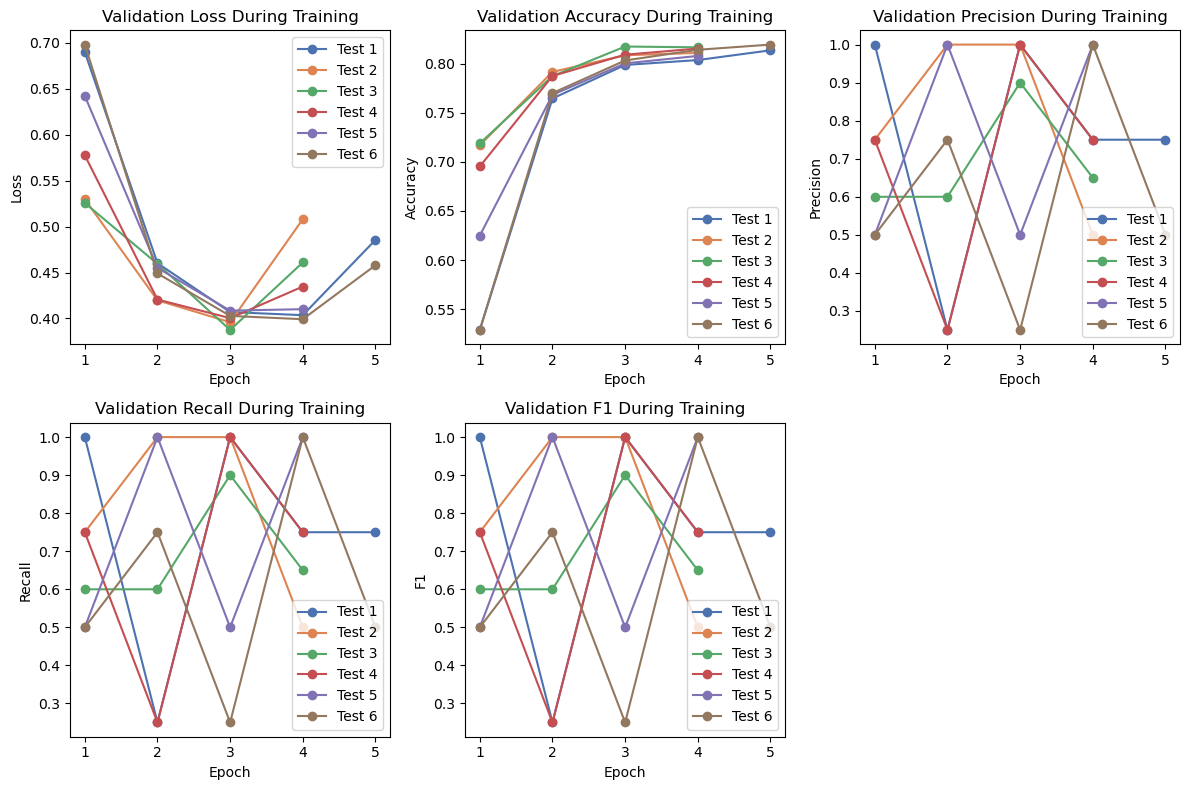

In [96]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

df = pd.read_csv('./results/all_train_results.csv')

metrics = df['metric'].unique()
models = df['model'].unique()
pal = sns.color_palette('deep', len(models))

model_color_dict = {}
for mod, color in zip(models, pal):
    model_color_dict[mod] = color
 
# Filter to validation data
df = df[df['set'] == 'val']
metrics = df['metric'].unique()

# Create subplots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
axs = axs.flatten()  # flatten to 1D array of Axes

for i, met in enumerate(metrics):
    if i >= len(axs):
        break
    ax = axs[i]
    
    for model in models:
        subset = df[(df['metric'] == met) & (df['model'] == model)] 
        ax.plot(subset['epoch'], subset['score'], marker='o', linestyle='-',
                c=model_color_dict[model], label=model)
    
    ax.set_title(f'Validation {met.capitalize()} During Training')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(met.capitalize())
    ax.legend()
axs[5].set_visible(False)
    
plt.tight_layout()
plt.show()

I successfully achieved a validation accuracy capping off at ~82%. For all configurations, the accuracy tended to increase quickly and converge soon after around 80%. It is not included in this output, but all models had issues overfitting to the training data despite me implementing label smoothing, dropout, and weight regularization in the model design. On the flip side, validation metrics were a good indicator of generalizability, as the test set performance for each configuration was almost identical to its validation performance (see './results for more detail on this). You will also notice that some of the trials did not complete all 5 epochs because I implemented early stopping if the validation loss increased. These trials took an average of ~5 hours with an upper end of 9 for more complex models and a lower end of 2 for lighter weight models. For reference, model 6 had the best validation accuracy of 0.8196.

In [97]:
df = df[(df['set'] == 'val') & (df['metric'] == 'accuracy')]
df.loc[df['score'].idxmax()]

epoch          5.0
set            val
metric    accuracy
score     0.819634
model       Test 6
Name: 282, dtype: object

As I remarked before, I wanted to be more systematic about finding the right model configuration and hyperparameters, so I ran an Optuna study for 2 days on the hpc (opt.py & opt.sb). The full output of that study is in './optuna.out', but the results at the end of 20 trials were:

Best trial:
  Value: 0.8285090114691426
  Params: {'batch_size': 32, 'num_heads': 16, 'd_model': 768, 'num_hidden_layers': 4, 'd_hidden': 2048, 'num_encoders': 7, 'lr': 6.871199163253075e-05, 'p_drop': 0.3099236390195026}
  Validation Loss: 0.4878299738967783
  Validation Accuracy: 0.8285090114691426

Note: While this was the best validation accuracy encountered thus far, it was not much better than any of the random configurations I tried before. When I discuss limitations below, I talk about why I think that is but since this configuration resulted in the best validation accuracy, I took these parameters and trained the model one more time to save its model state. The results of this training in './results/etpol_metrics.csv' and the parameters are in './results/etpol_params.txt'. 

### Annotating the subreddit data & RESULTS

In annotate.py, I annotated the subreddit post dataset with ETPOL's right or left classification. The full post dataset is in './scrape/subreddits_cleaned.csv' and the subsequent annotated version is in './annotated_subreddits/posts_w_pol.csv'. All I did to annotate was feed the content of each post into ETPOL and have it classify the post as leaning right or left (which took about 5 minutes on the hpc for ~3000 posts). Below, I compare the subreddits based on their political leanings.

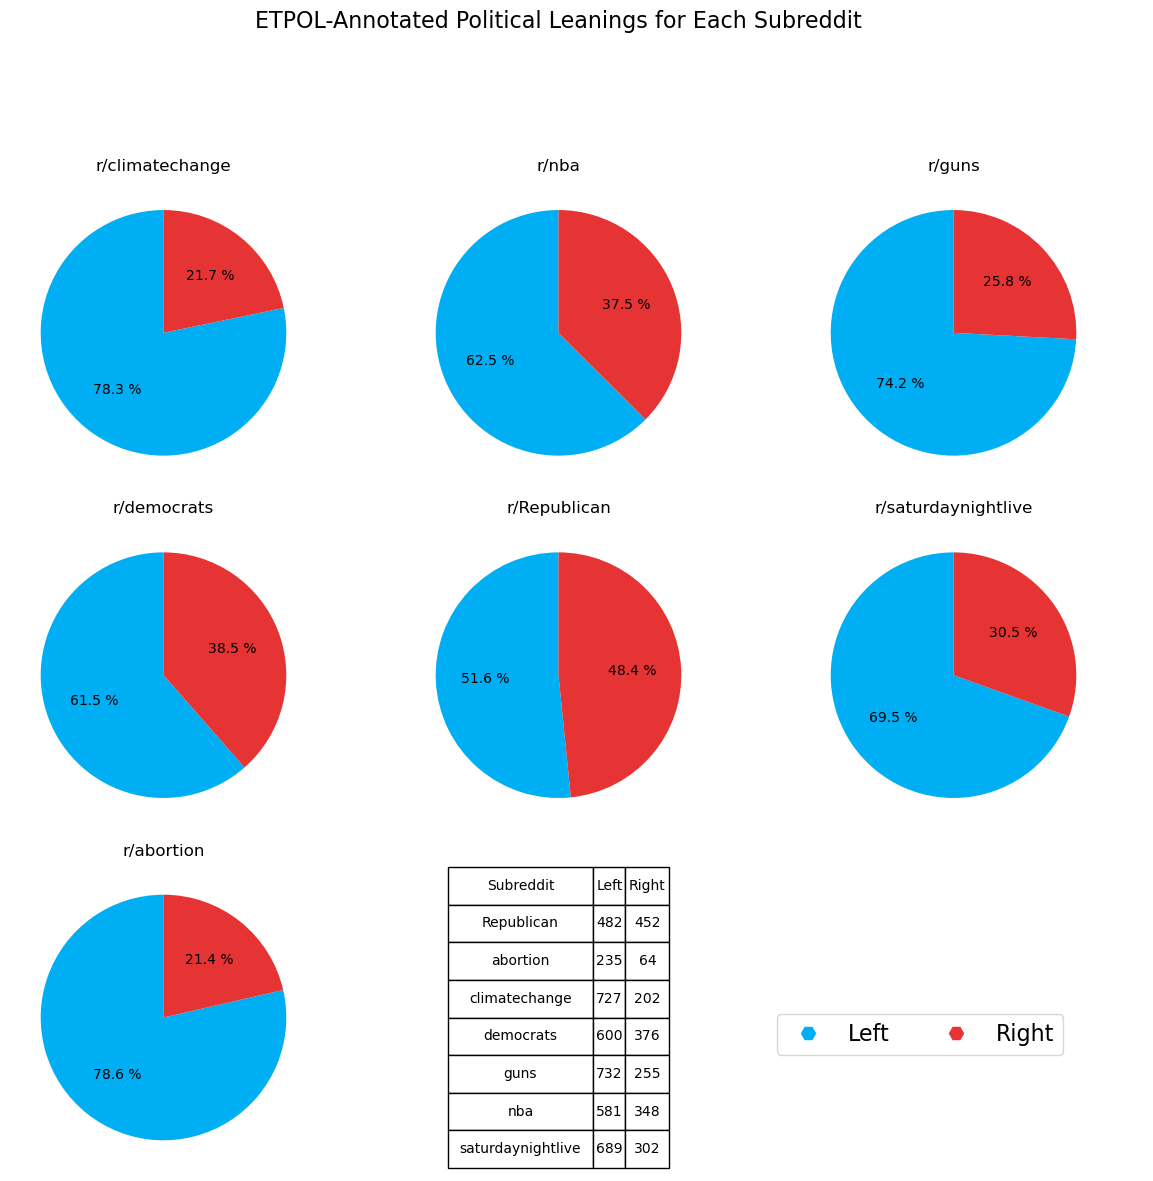

In [98]:
posts = pd.read_csv('./annotated_subreddit/posts_w_pol.csv')

subs = ['climatechange', 'nba', 'guns','democrats', 'Republican', 'saturdaynightlive', 'abortion']

colors = {'Left': '#00AEF3', 'Right': '#e53433'}


data = posts.groupby('subreddit')['affiliation'].value_counts().reset_index()
data = data.pivot(index= 'subreddit', columns='affiliation', values='count')
data = data.rename_axis(None, axis=1)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,12))
axs = axs.flatten()
for i, sub in enumerate(subs):
    if i >= len(subs): break
    ax = axs[i]
    sizes = data.loc[sub, ['left', 'right']].values
    labels = ['Left', 'Right']
    ax.pie(sizes, labels=None, autopct='%1.1f %%', startangle=90, colors=[colors[label] for label in labels])
    ax.set_title(f'r/{sub}')

ax_table = axs[7]
ax_table.axis('tight')
ax_table.axis('off')
table = ax_table.table(
    cellText=data.reset_index().values,
    colLabels=['Subreddit', 'Left', 'Right'],
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(data.columns) + 1)))
table.scale(2.5, 2)

# Hide any unused subplots
for j in range(8, len(axs)):
    axs[j].axis('off')

fig.legend(
    handles=[plt.Line2D([0], [0], color=colors[label], marker='H', linestyle='', markersize=10) for label in labels],
    labels=labels,
    loc='lower right',
    bbox_to_anchor=(0.93, 0.1),
    ncol=4,
    fontsize=16
)
fig.suptitle('ETPOL-Annotated Political Leanings for Each Subreddit', fontsize = 16)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
    


As demonstrated by the pie charts, ETPOL decided that the majority politcial ideology of posts on every subreddit was left-wing. We have: r/Republican with 482 left vs 452 right; r/abortion with 235 left vs 64 right; r/climatechange with 727 left vs 202 right; r/democrats with 600 left vs 376 right; r/guns with 732 left vs 255 right; r/nba with 581 left vs 348 right; r/saturdaynightlive 689 left vs 302 right. If we are to take these results at face value they are quite shocking. One would not expect a majority of posts on social media threads about guns or the literal Republican party to be considered left-wing. On the other hand, seeing r/climatechange dominated by left-wing posts is less surprising. Quite honestly, it would have been nice to see a more even split on this subreddit to demonstrate both sides coming to the table on such an important issue, but that was an improbable hope especially given what seems like a left-wing bias in ETPOL.

### Conclusions, Implications, & Limitations

Clearly, ETPOL favored classifying post content as left-wing. Across the board of a variety of subreddits, differing extensively in both their political activity and orientation, it identifed that the majority of posts on each one were left-wing. While it is plausible and possibly quite likely that left-wing voices would dominate the climate change, democrats, and snl threads, the results for the rest of the subreddits are questionable. One would not expect r/Republican to have more left-wing posts than right; the same can be said for r/guns. I included these as a sort of control to see if any bias in my model might appear, which certainly seems to be the case here. Despite the descent 82% accuracy performance on validation and test sets, I'm afraid there are a few notable limitations to ETPOL that call these results into question.

Transformers work best with huge amounts of data. In order to properly leverage its ability to model long context relationships between words, massive copora are required. Without this, transformers tend to only learn more surface level word relationships. Additionally, since I trained my own tokenizer I couldn't use pre-trained embeddings like gloVe or Word2Vec. This meant that even the token embeddings of my model were initialized randomly, further emphasizing the need for more data.


### Future Work

### References

AlDahoul, N., Rahwan, T. & Zaki, Y. PoLYTC: a novel BERT-based classifier to detect political leaning of YouTube videos based on their titles. J Big Data 11, 80 (2024). https://doi.org/10.1186/s40537-024-00946-1

Michelle YoungJin Kim and Kristen Marie Johnson. 2022. CLoSE: Contrastive Learning of Subframe Embeddings for Political Bias Classification of News Media. In Proceedings of the 29th International Conference on Computational Linguistics, pages 2780–2793, Gyeongju, Republic of Korea. International Committee on Computational Linguistics.


Misra, A., & Basak, S. (2016). Political bias analysis.

Biessmann, F. (2016). Automating Political Bias Prediction. arXiv [Cs.SI]. Retrieved from http://arxiv.org/abs/1608.02195

Durant, K. T., & Smith, M. D. (2006, August). Mining sentiment classification from political web logs. In Proceedings of Workshop on Web Mining and Web Usage Analysis of the 12th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (WebKDD-2006), Philadelphia, PA (Vol. 16).